# Get relevant packages

In [1]:
import pandas as pd
import numpy as np
#np.set_printoptions(threshold=np.nan)
import re
import matplotlib.pyplot as plt
import seaborn as sns



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', -1)



# Let's pull in relevant files
See USDA database http://ilsina.org/our-work/research-tools-open-data/bfpd/

In [2]:
products=pd.read_csv('/Users/meleciawright/Google Drive/csvs/products.csv',low_memory=False, encoding='mac_roman')
serving=pd.read_csv('/Users/meleciawright/Google Drive/csvs/Serving_Size.csv',low_memory=False,encoding='mac_roman')
nutrients=pd.read_csv('/Users/meleciawright/Google Drive/csvs/nutrient.csv',low_memory=False,encoding='mac_roman')
dflist=[serving,products, nutrients]
for x in dflist:print(len(x))

237910
239089
3231488


# Change strings to lower case

In [4]:
products['name']=products.long_name.str.lower().str.capitalize()
products['unqname']=products.manufacturer.str.lower().str.capitalize()+': '+products.long_name.str.lower()
products['ingredients']=products.ingredients_english.str.lower().str.capitalize()

products[['name','unqname','ingredients']].head()

,name,unqname,ingredients
0,Mochi ice cream bonbons,"G. t. japan, inc.: mochi ice cream bonbons","Ice cream ingredients: milk, cream, sugar, strawberries (strawberries, sugar), corn syrup solids, skim milk, whey, natural flavor, guar gum, mono & diglycerides, beet juice and beet powder (for color), cellulose gum, locust bean gum, carrageenan. coating ingredients: sugar, water, rice flour, trehalose, egg whites, beet juice and beet powder (for color), dusted with corn & potato starch"
1,Chipotle barbecue sauce,Fresh & easy: chipotle barbecue sauce,"Water, sugar, tomato paste, molasses, distilled vinegar, contains 2% or less of: corn starch, salt, dried chipotle pepper, natural smoke flavor, mustard flour, dried garlic, dried onion, spices."
2,Hot & spicy barbecue sauce,Fresh & easy: hot & spicy barbecue sauce,"Sugar, water, distilled vinegar, tomato paste, molasses, modified corn starch, salt, pineapple juice concentrate, contains 1% or less of: jalapeno peppers, spice, caramel color, natural flavor, xanthan gum, garlic powder, tamarind extract."
3,Barbecue sauce,Fresh & easy: barbecue sauce,"Tomato puree (water, tomato paste), sugar, distilled vinegar, molasses, water, modified corn starch, salt, bourbon whiskey, contains 1% or less of: mustard flour, spice, dried onion, dried garlic, natural flavor, xanthan gum, caramel color."
4,Barbecue sauce,Fresh & easy: barbecue sauce,"Sugar, distilled vinegar, water, tomato paste, honey, molasses, modified corn starch, salt, contains 1% or less of: natural flavor, pineapple juice concentrate, spice, caramel color, xanthan gum, garlic powder, tamarind extract."


# Check for duplicates

In [5]:
(products.name.nunique(),products.unqname.nunique(),products.ingredients.nunique(),products.unqname.notnull().sum(),
 products.ingredients.notnull().sum(),products.gtin_upc.nunique())
#all UPC codes are unique but there are some product names that are similar, and after merging manufacturer info
#with product names there are still ~45000 that are not unique. For simplicity, I will drop the non-unique productnames

(147794, 194279, 176656, 238258, 236539, 239089)

In [6]:
#products2=products[products.unqname.notnull()].drop_duplicates(subset=['unqname']) 
products2=products.drop_duplicates(subset=['ingredients']) 
products2=products2.drop_duplicates(subset=['unqname']) 

products2.ingredients.nunique()

152412

# Let's see the nutrient file

In [13]:
nutrients.head()
#goal here is to create a wide version so that each row has the nutrient within individual product IDs

,NDB_No,Nutrient_Code,Nutrient_name,Derivation_Code,Output_value,Output_uom
0,45127487,203,Protein,LCGA,4.3,g
1,45127487,204,Total lipid (fat),LCGA,18.9,g
2,45127487,205,"Carbohydrate, by difference",LCGA,72.8,g
3,45127487,207,Ash,LCGA,2.0,g
4,45127487,255,Water,LCGA,2.0,g


In [14]:
nutrients.Nutrient_name.value_counts()

Carbohydrate, by difference           237635
Total lipid (fat)                     237559
Protein                               237432
Sodium, Na                            236887
Energy                                228500
Sugars, total                         223394
Fatty acids, total saturated          205694
Cholesterol                           202966
Fiber, total dietary                  198171
Iron, Fe                              196981
Calcium, Ca                           196065
Fatty acids, total trans              194801
Vitamin C, total ascorbic acid        178809
Vitamin A, IU                         174501
Potassium, K                          53337 
Fatty acids, total monounsaturated    33822 
Fatty acids, total polyunsaturated    33799 
Vitamin D                             27668 
Niacin                                16071 
Thiamin                               15579 
Riboflavin                            15234 
Sugars, added                         11033 
Vitamin B-

In [15]:
#example nutrient data
nutrients[nutrients.Nutrient_name=='Carbohydrate, by difference'].describe()

,NDB_No,Nutrient_Code,Output_value
count,2.376350e+05,237635.0,237635.000000
mean,4.520707e+07,205.0,33.574563
std,1.023677e+05,0.0,29.423991
min,4.500152e+07,205.0,0.000000
25%,4.513822e+07,205.0,6.670000
50%,4.520950e+07,205.0,23.530000
75%,4.528504e+07,205.0,60.000000
max,4.537643e+07,205.0,100.000000


In [10]:
#only keep the nutrients that'll form the basis of recommendation
nutrientstokeep=['Total lipid (fat)',  'Carbohydrate, by difference','Sugars, total', 'Protein','Energy']
nutrprun=nutrients.loc[nutrients['Nutrient_name'].isin(nutrientstokeep)].drop_duplicates(['NDB_No','Nutrient_name']) 
nutrprun.Nutrient_name.value_counts()

Carbohydrate, by difference    237635
Total lipid (fat)              237559
Protein                        237432
Energy                         228494
Sugars, total                  223394
Name: Nutrient_name, dtype: int64

In [8]:
nutrprun.head(),len(nutrprun)

(      NDB_No  Nutrient_Code                Nutrient_name Derivation_Code  Output_value Output_uom
 0   45127487  203            Protein                      LCGA            4.3           g        
 1   45127487  204            Total lipid (fat)            LCGA            18.9          g        
 2   45127487  205            Carbohydrate, by difference  LCGA            72.8          g        
 5   45127487  269            Sugars, total                LCGA            39.3          g        
 29  45128706  203            Protein                      LCGA            10.1          g        ,
 1164520)

In [11]:
#transpose file from long to wide so each product id only occupies a single row
nutrientl=nutrprun.copy()
nutrientw=nutrientl.pivot(index='NDB_No',columns='Nutrient_name', values='Output_value')
nutrientw.head()

Nutrient_name,"Carbohydrate, by difference",Energy,Protein,"Sugars, total",Total lipid (fat)
NDB_No,,,,,
45001524,35.00,200.0,2.5,30.00,6.25
45001528,43.24,162.0,0.0,37.84,0.00
45001529,41.18,176.0,0.0,35.29,0.00
45001530,34.29,143.0,0.0,28.57,0.00
45001531,45.95,189.0,0.0,43.24,0.00


In [49]:
fat=nutrprun.loc[nutrprun['Nutrient_name']=='Total lipid (fat)'][['NDB_No','Output_value']].rename(columns={'NDB_No':'NDB_Number','Output_value':'fat g'}) 
protein=nutrprun.loc[nutrprun['Nutrient_name']=='Protein'][['NDB_No','Output_value']].rename(columns={'NDB_No':'NDB_Number','Output_value':'protein g'}) 
carbs=nutrients[nutrients.Nutrient_name=='Carbohydrate, by difference'][['NDB_No','Output_value']].rename(columns={'NDB_No':'NDB_Number','Output_value':'carbs g'}) 
sugars=nutrprun.loc[nutrprun['Nutrient_name']=='Sugars, total'][['NDB_No','Output_value']].rename(columns={'NDB_No':'NDB_Number','Output_value':'sugars g'})   

for nutr in [protein,fat,carbs,sugars]:print(len(nutr))

for x in [protein,fat,carbs,sugars]:print(x.info())

237432
237559
237635
223394
<class 'pandas.core.frame.DataFrame'>
Int64Index: 237432 entries, 0 to 3231472
Data columns (total 2 columns):
NDB_Number    237432 non-null int64
protein g     237432 non-null float64
dtypes: float64(1), int64(1)
memory usage: 5.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 237559 entries, 1 to 3231473
Data columns (total 2 columns):
NDB_Number    237559 non-null int64
fat g         237559 non-null float64
dtypes: float64(1), int64(1)
memory usage: 5.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 237635 entries, 2 to 3231474
Data columns (total 2 columns):
NDB_Number    237635 non-null int64
carbs g       237635 non-null float64
dtypes: float64(1), int64(1)
memory usage: 5.4 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 223394 entries, 5 to 3231475
Data columns (total 2 columns):
NDB_Number    223394 non-null int64
sugars g      223394 non-null float64
dtypes: float64(1), int64(1)
memory usage: 5.1 MB
None


In [51]:
fat['fat g'].isnull().sum(),protein['protein g'].isnull().sum(),sugars['sugars g'].isnull().sum(),carbs['carbs g'].isnull().sum()

0

In [55]:
on=['NDB_Number']
allnutr=pd.merge(pd.merge(pd.merge(protein,fat,how='outer',on=on),
         carbs,how='outer',on=on),
    sugars, how='outer',on=on ) 

allnutr['energy (kcal)']=4*(allnutr['protein g']+allnutr['carbs g'])+9*allnutr['fat g']
allnutr.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 237809 entries, 0 to 237808
Data columns (total 6 columns):
NDB_Number       237809 non-null float64
protein g        237432 non-null float64
fat g            237559 non-null float64
carbs g          237635 non-null float64
sugars g         223394 non-null float64
energy (kcal)    237095 non-null float64
dtypes: float64(6)
memory usage: 12.7 MB


In [56]:
for col in allnutr.columns: print (col, allnutr[col].isnull().sum())

NDB_Number 0
protein g 377
fat g 250
carbs g 174
sugars g 14415
energy (kcal) 714


# add serving

In [57]:
#use servings so you can create a normalized nutrient density for each item
allnutrsv=pd.merge(allnutr,serving,left_on='NDB_Number', right_on='NDB_No',how='left')
#remove those with missing serving size
allnutrsv=allnutrsv[allnutrsv.Serving_Size.notnull()]
#standardize so that nutrients are all out of a serving_size of 100
print(allnutrsv.head())
def serv100(col) :
    allnutrsv[col]= 100*allnutrsv[col]/ allnutrsv['Serving_Size']
    return 
for coll in ['fat g','protein g','sugars g','carbs g','energy (kcal)' ]:
    serv100(coll)
allnutrsv.head()

   NDB_Number  protein g  fat g  carbs g  sugars g  energy (kcal)    NDB_No  Serving_Size Serving_Size_UOM  Household_Serving_Size Household_Serving_Size_UOM Preparation_State
0  45127487.0  4.3        18.9   72.8     39.3      478.5          45127487  29.0          g                14.0                    Cookies                    UNPREPARED      
1  45128706.0  10.1       8.5    76.4     3.0       422.5          45128706  12.0          g                1.0                     Package                    UNPREPARED      
2  45129911.0  3.0        10.2   77.0     34.6      411.8          45129911  44.0          g                4.0                     Bars                       UNPREPARED      
5  45128734.0  17.1       5.9    15.3     1.6       182.7          45128734  85.0          g                1.0                     patty                      UNPREPARED      
8  45127542.0  3.6        0.2    75.2     51.7      317.0          45127542  31.0          g                11.0        

,NDB_Number,protein g,fat g,carbs g,sugars g,energy (kcal),NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State
0,45127487.0,14.827586,65.172414,251.034483,135.517241,1650.000000,45127487,29.0,g,14.0,Cookies,UNPREPARED
1,45128706.0,84.166667,70.833333,636.666667,25.000000,3520.833333,45128706,12.0,g,1.0,Package,UNPREPARED
2,45129911.0,6.818182,23.181818,175.000000,78.636364,935.909091,45129911,44.0,g,4.0,Bars,UNPREPARED
5,45128734.0,20.117647,6.941176,18.000000,1.882353,214.941176,45128734,85.0,g,1.0,patty,UNPREPARED
8,45127542.0,11.612903,0.645161,242.580645,166.774194,1022.580645,45127542,31.0,g,11.0,Pieces,UNPREPARED


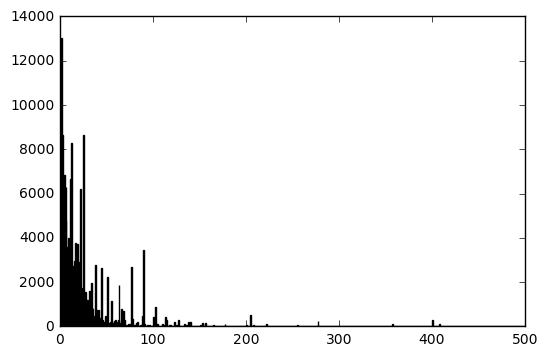

In [60]:
plt.hist(allnutrsv['protein g'][allnutrsv['protein g']!=0] ,range(0,500) )
plt.show()

In [194]:
allnutrsv=allnutrsv.fillna(0)
allnutrsv['energy (kcal)']=allnutrsv['energy (kcal)'].astype(int)
allnutrsv['protein g']=allnutrsv['protein g'].astype(int)
allnutrsv['fat g']=allnutrsv['fat g'].astype(int)
allnutrsv['sugars g']=allnutrsv['sugars g'].astype(int)
allnutrsv['carbs g']=allnutrsv['carbs g'].astype(int)


In [199]:
nutrpro=pd.merge(allnutrsv,products2, on='NDB_Number',  how= 'inner')
nutrpro.head() 
nlist= ['energy (kcal)','protein g','fat g','carbs g','sugars g']


for x in [nutrpro,allnutrsv,products2]:print(len(x), x.info())
for n in nlist:print(nutrpro[n].isnull().sum())

#though some nutrient information is missing, inspect further to see how, why, or just delete, in the interest of 
#retaining a larger body of data I'll just fill for now
 
#nutrpro=nutrpro.fillna(0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152007 entries, 0 to 152006
Data columns (total 22 columns):
NDB_Number                    152007 non-null float64
protein g                     152007 non-null int64
fat g                         152007 non-null int64
carbs g                       152007 non-null int64
sugars g                      152007 non-null int64
energy (kcal)                 152007 non-null int64
NDB_No                        152007 non-null int64
Serving_Size                  152007 non-null float64
Serving_Size_UOM              152007 non-null object
Household_Serving_Size        152007 non-null float64
Household_Serving_Size_UOM    152007 non-null object
Preparation_State             152007 non-null object
long_name                     152007 non-null object
data_source                   152007 non-null object
gtin_upc                      152007 non-null object
manufacturer                  152006 non-null object
date_modified                 152007 non-nul

# create categories

In [200]:
nutrpro.loc[(nutrpro.unqname.str.contains('ice cream'))
             |(nutrpro.unqname.str.contains('gelato')), 'pcat'] = 'ice cream' 
icdf=nutrpro[nutrpro['pcat']=='ice cream']
 

In [12]:
products.long_name.iloc[10]

'FRESH & EASY, SWEET HOT MUSTARD'

In [13]:
productsnew=products.copy()

In [14]:
productsnew['category']=None

In [18]:
productsnew.head(1)

,NDB_Number,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,category
0,45001524,MOCHI ICE CREAM BONBONS,LI,019022128593,"G. T. Japan, Inc.",11/15/2017 19:19:38,11/15/2017 19:19:38,"ICE CREAM INGREDIENTS: MILK, CREAM, SUGAR, STRAWBERRIES (STRAWBERRIES, SUGAR), CORN SYRUP SOLIDS, SKIM MILK, WHEY, NATURAL FLAVOR, GUAR GUM, MONO & DIGLYCERIDES, BEET JUICE AND BEET POWDER (FOR COLOR), CELLULOSE GUM, LOCUST BEAN GUM, CARRAGEENAN. COATING INGREDIENTS: SUGAR, WATER, RICE FLOUR, TREHALOSE, EGG WHITES, BEET JUICE AND BEET POWDER (FOR COLOR), DUSTED WITH CORN & POTATO STARCH",None


In [ ]:
for x in pasta:
    productsnew.loc[productsnew['long_name'].str.contains(x) & productsnew['category'].isnull(), 'category'] = 'PASTA'

In [201]:
nutrpro.loc[(nutrpro.unqname.str.contains('pasta'))
              |(nutrpro.unqname.str.contains('macaroni'))
              |(nutrpro.unqname.str.contains('rotini'))
              |(nutrpro.unqname.str.contains('linguin'))
              |(nutrpro.unqname.str.contains('angel hair'))
              |(nutrpro.unqname.str.contains('lasagne'))
              |(nutrpro.unqname.str.contains('fetuccin'))
              |(nutrpro.unqname.str.contains('ziti'))
              |(nutrpro.unqname.str.contains('fusill'))
              |(nutrpro.unqname.str.contains('spaghett'))
              |(nutrpro.unqname.str.contains('farfall'))
              |(nutrpro.unqname.str.contains('tortellin'))
              |(nutrpro.unqname.str.contains('elbow'))
              |(nutrpro.unqname.str.contains('raviol'))
              |(nutrpro.unqname.str.contains('bowtie')), 'pcat'] = 'pasta' 
pastadf=nutrpro[nutrpro['pcat']=='pasta']

nutrpro.loc[(((nutrpro.unqname.str.contains('cereal')) 
            |(nutrpro.unqname.str.contains('corn flake'))
            |(nutrpro.unqname.str.contains('raisin bran'))
            |(nutrpro.unqname.str.contains('oat cereal'))
            |(nutrpro.unqname.str.contains('oatmeal cereal'))
             |(nutrpro.unqname.str.contains('froot loops'))))
             ,'pcat'] = 'breakfast/cereal' 
cereal=nutrpro[nutrpro['pcat']=='breakfast/cereal' ]

nutrpro.loc[((nutrpro.unqname.str.contains('yogurt')) 
            |(nutrpro.unqname.str.contains('yoghurt')))  ,'pcat'] = 'yogurt' 
yogurt=nutrpro[nutrpro['pcat']=='yogurt']



nutrpro.loc[(nutrpro.unqname.str.contains('burger')) 
             |(nutrpro.unqname.str.contains('patties'))
             |(nutrpro.unqname.str.contains('patty'))
             |(nutrpro.unqname.str.contains('sausage'))
                     |(nutrpro.unqname.str.contains('hot dog')) 
             |(nutrpro.unqname.str.contains('meatball')), 'pcat'] = 'meat products e.g. burgers'  
meats=nutrpro[nutrpro['pcat']== 'meat products e.g. burgers']

nutrpro.loc[(nutrpro.unqname.str.contains('soup') 
            |(nutrpro.unqname.str.contains('soup')))  ,'pcat'] = 'soup' 
soup=nutrpro[nutrpro['pcat']=='soup']



on=['NDB_Number', 'protein g', 'fat g', 'carbs g', 'sugars g', 'energy (kcal)', 'NDB_No', 'Serving_Size', 'Serving_Size_UOM', 'Household_Serving_Size', 'Household_Serving_Size_UOM', 'Preparation_State', 'long_name', 'data_source', 'gtin_upc', 'manufacturer', 'date_modified', 'date_available', 'ingredients_english', 'name', 'unqname', 'ingredients', 'pcat']#all of these have the same column names
allcats=pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(icdf,soup,on=on,how='outer'), 
                 meats,on=on,how='outer'), 
                yogurt,on=on,how='outer'),
                cereal,on=on,how='outer'),
                pastadf,on=on,how='outer') 

for x in [ soup, meats, yogurt, cereal,pastadf, icdf,allcats]:print(len(x))
allcats.info()

In [207]:
allcats.head()

,NDB_Number,protein g,fat g,carbs g,sugars g,energy (kcal),NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,name,unqname,ingredients,pcat
0,45266835.0,3.0,7.0,36.0,30.0,229.0,45266835.0,88.0,g,5.0,OZA,0,ITALIAN STYLE ICE CREAM GELATO,LI,070682109667,Velvet Ice Cream Co.,7/14/2017 17:54:20,7/14/2017 17:54:20,"CREAM, SUGAR, SKIM MILK, CORN SYRUP, WHEY, MONO- & DIGLYCERIDES, CELLULOSE GUM, GUAR GUM, CARRAGEENAN, SALTY CARAMEL VARIEGATE (CORN SYRUP, SWEETENED CONDENSED MILK (CONDENSED MILK SUGAR), SUGAR,SEA SALT, PECTIN, XANTHAN GUM, SODIUM BICARBONATE), SALTY CARAMEL BASE (BROWN SUGAR, BUTTER, CREAM, INVERT SUGAR, CARAMEL COLOR, SEA SALT, CORN STARCH, SOY LECITHIN.",Italian style ice cream gelato,Velvet ice cream co.: italian style ice cream gelato,"Cream, sugar, skim milk, corn syrup, whey, mono- & diglycerides, cellulose gum, guar gum, carrageenan, salty caramel variegate (corn syrup, sweetened condensed milk (condensed milk sugar), sugar,sea salt, pectin, xanthan gum, sodium bicarbonate), salty caramel base (brown sugar, butter, cream, invert sugar, caramel color, sea salt, corn starch, soy lecithin.",ice cream
1,45269057.0,4.0,11.0,24.0,23.0,215.0,45269057.0,85.0,g,1.0,PACKAGE,0,COTTON CANDY FLAVORED ICE CREAM,LI,816193010289,DIPPIN'S DOT'S,7/14/2017 19:51:27,7/14/2017 19:51:27,"MILK, CREAM, SUGAR, ARTIFICIAL FLAVORS, BLUE #1, RED #40, LESS THAN 0.5% OF (MONO & DIGLYCERIDES, GUAR GUM, CARRAGEENAN, LOCUST BEAN GUM).",Cotton candy flavored ice cream,Dippin's dot's: cotton candy flavored ice cream,"Milk, cream, sugar, artificial flavors, blue #1, red #40, less than 0.5% of (mono & diglycerides, guar gum, carrageenan, locust bean gum).",ice cream
2,45269040.0,4.0,11.0,33.0,27.0,249.0,45269040.0,85.0,g,1.0,PACKAGE,0,CHOCOLATE CHIP COOKIE DOUGH ICE CREAM,LI,816193010159,"Dippin' Dots, L.L.C.",8/28/2017 4:36:19,8/28/2017 4:36:19,"MILK, CREAM, SUGAR, NATURAL FLAVORS, VANILLA, LESS THAN 0.5% OF (MONO & DIGLYCERIDES, GUAR GUM, CARRAGEENAN, LOCUST BEAN GUM). COOKIE DOUGH: WHEAT FLOUR, BROWN SUGAR, MARGARINE [LIQUID AND PARTIALLY HYDROGENATED SOYBEAN OIL, WATER, SALT, CONTAINS LESS THAN 2% OF WHEY SOLIDS, SOY LECITHIN, VEGETABLE MONO AND DIGLYCERIDES, SODIUM BENZOATE (PRESERVATIVE) NATURAL AND ARTIFICIAL FLAVORS, BETA CAROTENE (COLOR), VITAMIN A PALMITATE ADDED], SUGAR, CHOCOLATE CHIPS (SUGAR, CHOCOLATE LIQUOR, COCOA BUTTER AND SOY LECITHIN), WATER, NATURAL FLAVORS, SALT, SODIUM BICARBONATE.",Chocolate chip cookie dough ice cream,"Dippin' dots, l.l.c.: chocolate chip cookie dough ice cream","Milk, cream, sugar, natural flavors, vanilla, less than 0.5% of (mono & diglycerides, guar gum, carrageenan, locust bean gum). cookie dough: wheat flour, brown sugar, margarine [liquid and partially hydrogenated soybean oil, water, salt, contains less than 2% of whey solids, soy lecithin, vegetable mono and diglycerides, sodium benzoate (preservative) natural and artificial flavors, beta carotene (color), vitamin a palmitate added], sugar, chocolate chips (sugar, chocolate liquor, cocoa butter and soy lecithin), water, natural flavors, salt, sodium bicarbonate.",ice cream
3,45267581.0,2.0,12.0,29.0,26.0,239.0,45267581.0,85.0,g,0.5,cup,0,ITALIAN VANILLA,LI,093959745115,Al Gelato Chicago LLC,7/14/2017 19:47:37,7/14/2017 19:47:37,"MILK, CREAM, SUGAR, NONFAT DRY MILK, LECITHIN, GUAR GUM, XANTHAN GUM, CARRAGEENAN GUM, NATURAL FLAVORS, PECTIN, CARAMEL COLOR, TURMERIC EXTRACT FOR COLOR, CITRIC ACID",Italian vanilla,Al gelato chicago llc: italian vanilla,"Milk, cream, sugar, nonfat dry milk, lecithin, guar gum, xanthan gum, carrageenan gum, natural flavors, pectin, caramel color, turmeric extract for color, citric acid",ice cream
4,45330594.0,11.0,5.0,37.0,16.0,252.0,45330594.0,65.0,g,0.5,cup,0,PANCAKES & WAFFLES LIGHT ICE CREAM,LI,858089003395,HALO TOP,3/10/2018 20:24:17,3/10/2018 20:24:17,"SKIM MILK, EGGS, ERY

In [208]:
#grab quintile cutoffs
newquant80=nutrpro[['protein g', 'sugars g', 'carbs g', 'energy (kcal)', 'fat g','pcat']
                  ].groupby(['pcat']).quantile([0.8])
newquant80=newquant80.reset_index().drop('level_1',axis=1)
newquant80.columns=['pcat','carbquan80', 'energyquan80', 'fatquan80', 'proteinquan80', 'sugarquan80']
newquant80.head()

,pcat,carbquan80,energyquan80,fatquan80,proteinquan80,sugarquan80
0,breakfast/cereal,288.0,1385.4,21.0,29.0,115.0
1,ice cream,47.0,376.6,19.0,6.0,36.0
2,meat products e.g. burgers,32.0,567.0,36.0,26.0,6.0
3,pasta,126.0,640.0,7.0,21.0,6.0
4,soup,127.8,768.0,3.0,14.0,5.0


In [209]:
#grab quintile cutoffs


newquant20=nutrpro[['protein g', 'sugars g', 'carbs g', 'energy (kcal)', 'fat g','pcat']
                  ].groupby(['pcat']).quantile([0.2])
newquant20.head()
#quantile = df[['category', 'price']].groupby('category').quantile([0.25,0.5,0.75])
newquant20=newquant20.reset_index().drop('level_1',axis=1)
newquant20.head()
newquant20.columns=['pcat','carbquan20', 'energyquan20', 'fatquan20', 'proteinquan20', 'sugarquan20']
newquant20.head()

,pcat,carbquan20,energyquan20,fatquan20,proteinquan20,sugarquan20
0,breakfast/cereal,143.0,737.0,3.0,13.0,28.0
1,ice cream,26.0,222.0,8.0,3.0,20.0
2,meat products e.g. burgers,2.0,170.0,5.0,8.0,0.0
3,pasta,6.0,49.0,1.0,1.0,0.0
4,soup,2.0,17.2,0.0,0.0,0.0


In [210]:
quants=pd.merge(newquant20,newquant80 ,on='pcat')
quants.head()

,pcat,carbquan20,energyquan20,fatquan20,proteinquan20,sugarquan20,carbquan80,energyquan80,fatquan80,proteinquan80,sugarquan80
0,breakfast/cereal,143.0,737.0,3.0,13.0,28.0,288.0,1385.4,21.0,29.0,115.0
1,ice cream,26.0,222.0,8.0,3.0,20.0,47.0,376.6,19.0,6.0,36.0
2,meat products e.g. burgers,2.0,170.0,5.0,8.0,0.0,32.0,567.0,36.0,26.0,6.0
3,pasta,6.0,49.0,1.0,1.0,0.0,126.0,640.0,7.0,21.0,6.0
4,soup,2.0,17.2,0.0,0.0,0.0,127.8,768.0,3.0,14.0,5.0


In [213]:
proquant=pd.merge(quants, allcats, on='pcat',how='right')
proquant.pcat.value_counts().sum()

17503

In [214]:

#using quintiles to define high and low quantities
proquant['hipro']=np.where(proquant['protein g']>proquant.proteinquan80,1,0)

proquant['lowcarb']=np.where(proquant['carbs g']< proquant.carbquan20,1,0)

proquant['lowsugar']=np.where(proquant['sugars g']<proquant.sugarquan20,1,0)

proquant['lowfat']=np.where(proquant['fat g']<proquant.fatquan20,1,0)
 
proquant['lowcal']=np.where(proquant['energy (kcal)']<proquant.energyquan20,1,0) 
 

proquant.head(1)



,pcat,carbquan20,energyquan20,fatquan20,proteinquan20,sugarquan20,carbquan80,energyquan80,fatquan80,proteinquan80,sugarquan80,NDB_Number,protein g,fat g,carbs g,sugars g,energy (kcal),NDB_No,Serving_Size,Serving_Size_UOM,Household_Serving_Size,Household_Serving_Size_UOM,Preparation_State,long_name,data_source,gtin_upc,manufacturer,date_modified,date_available,ingredients_english,name,unqname,ingredients,hipro,lowcarb,lowsugar,lowfat,lowcal
0,breakfast/cereal,143.0,737.0,3.0,13.0,28.0,288.0,1385.4,21.0,29.0,115.0,45127931.0,39.0,7.0,137.0,30.0,774.0,45127931.0,51.0,g,1.0,Cup,UNPREPARED,KASHI GOLEAN CEREAL VANILLA GRAHAM 13.2OZ,GDSN,00018627923084,Kashi US,2/9/2017 18:19:41,2/9/2017 19:00:48,"KASHI SEVEN WHOLE GRAIN HONEY PUFF CEREAL (HARD RED WHEAT, BROWN RICE, HONEY, CANE SYRUP, BARLEY, TRITICALE, OATS, RYE, BUCKWHEAT, SESAME SEEDS), DEGERMINATED YELLOW CORN FLOUR, EXPELLER PRESSED SOY GRITS, GROUND DEGERMINATED CORN, CANE SYRUP, EXPELLER PRESSED SOY PROTEIN ISOLATE, OAT FIBER, WHEAT BRAN, ROLLED OATS, DRIED CANE SYRUP, EXPELLER PRESSED SOY FLOUR, CORN BRAN, KASHI SEVEN WHOLE GRAINS & SESAME FLOUR (WHOLE: OATS, HARD RED WHEAT, RYE, BROWN RICE, TRITICALE, BARLEY, BUCKWHEAT, SESAME SEEDS), BROWN RICE FLOUR, NATURAL FLAVORS, HONEY, BROWN RICE SYRUP, SALT, MOLASSES, BAKING SODA, VITAMIN E (MIXED TOCOPHEROLS) FOR FRESHNESS, ANNATTO EXTRACT COLOR.",Kashi golean cereal vanilla graham 13.2oz,Kashi us: kashi golean cereal vanilla graham 13.2oz,"Kashi seven whole grain honey puff cereal (hard red wheat, brown rice, honey, cane syrup, barley, triticale, oats, rye, buckwheat, sesame seeds), degerminated yellow corn flour, expeller pressed soy grits, ground degerminated corn, cane syrup, expeller pressed soy protein isolate, oat fiber, wheat bran, rolled oats, dried cane syrup, expeller pressed soy flour, corn bran, kashi seven whole grains & sesame flour (whole: oats, hard red wheat, rye, brown rice, triticale, barley, buckwheat, sesame seeds), brown rice flour, natural flavors, honey, brown rice syrup, salt, molasses, baking soda, vitamin e (mixed tocopherols) for freshness, annatto extract color.",1,1,0,0,0


In [215]:
#finalize the database you'll use

proquant.to_csv('proquantfeb11.csv')

proquant[['unqname']].to_json('productnamelist6.json', orient='values')

#matrix with word2vec ingredient vectors
vecsapp11=vecsuse[proquant.index.tolist()]
pickle.dump(vecsapp, open("vecsapp11.pkl", 'wb'))
print(len(vecsapp),len(proquant))

In [217]:
 
vecsapp11=vecsuse[proquant.index.tolist()]
pickle.dump(vecsapp, open("vecsapp11.pkl", 'wb'))
print(len(vecsapp11),len(proquant))

17503 17503


In [191]:
#example code for app 
unqname='Le pain des fleur: le pain des fleur, 100% organic quinoa crispbread'
ng='hipro'
if ng=='hipro':
    nutr='protein g'
    lab='More protein(g)/serving than 75% of products in this food category'
if ng=='lowfat'  :
    nutr='fat g'
    lab='Less fat(g)/serving than 25% of products in this food category'
if ng=='lowcarb'  :
    nutr='carbs g'
    lab= 'Fewer carbs(g)/serving than 25% of products in this food category'
if ng=='lowcal'  :
    nutr='energrep'
    lab='Fewer calories/serving than 25% of products in this food category'
if ng=='lowsugar'  :
    nutr='sugars g'
    lab='Fewer grams of sugar/serving than 25% of products in this food category'

#open a file, where you stored the word2vec info
import pickle
file = open('vecsapp.pkl', 'rb')
vecsapp = pickle.load(file)
file.close()
#pull in the nutrientdata
proquantapp=pd.read_csv('proquantfeb10.csv', low_memory=False)
   
#find the location of item in database and word2vec matrix:
name='Kashi golean cereal vanilla graham 13.2oz'

indname=proquantapp[proquantapp['unqname']==unqname].index.values.item()
vecname=vecsapp[indname]

#find index of all elements of that category
catname=proquantapp.ix[indname,'pcat'] 
catindex=proquantapp[proquantapp['pcat']==catname].index.tolist()
#print(len(catindex))

catdf=proquantapp[proquantapp['pcat']==catname]

catnutdf=catdf[catdf[ng]==1]

#len(catnutdf)

catnutdfind=catnutdf.index.tolist() 
catvec=vecsapp[catnutdfind] 
#from sklearn.metrics.pairwise import cosine_similarity
res=cosine_similarity(vecname.reshape(1,-1), catvec) 

ind = np.argpartition(res.reshape(-1), -5)[-5:] 
#ind

#print(ind,res.reshape(-1)[ind])
#proquantapp.iloc[ind][['pcat','name','ingredients','protein g']]
pd.merge(catnutdf.reset_index().iloc[ind][['name','ingredients',nutr]],
         proquantapp.reset_index()[['name','ingredients',nutr]].iloc[[211]],how='outer' )

,name,ingredients,protein g
0,Milano italian bread,"Enriched wheat flour bleached (wheat flour, barley malt, niacin, iron, thiamine mononitrate, riboflavin, folic acid), water, yeast, high fructose corn syrup, contains 2% or less of the following: wheat, gluten, soybean oil, salt, corn flour, acetic acid, lactic acid, canola oil, yeast nutrients (calcium sulfate, monocalcium phosphate, ammonium sulfate), dough conditioner (monoglycerides, ascorbic acid), calcium propionate (preservative), enzyme, soy lecithin.",33.333333
1,Split top wheat bread,"Enriched wheat flour bleached (wheat flour, malted barley flour, niacin, iron, thiamine mononitrate, riboflavin, folic acid), water, high fructose corn syrup, wheat bran, wheat, yeast, wheat gluten, contains 2% or less of the following: soybean oil, honey, molasses, salt, cultured wheat flour, rye, wheat germ, dough conditioner (monoglycerides, ascorbic acid), yeast nutrients (calcium sulfate, ammonium sulfate), enzyme, soy lecithin.",41.148148
2,"Acme, sourdough bread","Enriched flour (wheat flour, malted barley flour, niacin, reduced iron, thiamin mononitrate, riboflavin, folic acid), water, yeast, wheat gluten, contains less than 2% of soybean oil, sugar, sodium stearoyl lactylate, salt, furmaric acid, datem, dextrose, sodium diacetate, lactic acid, silicon dioxide, ascorbic acid, enzymes.",38.250000
3,Enriched butterbread,"Unbleached enriched flour (wheat flour, malted barley flour, niacin, reduced iron, thiamin mononitrate, riboflavin, folic acid), water, sugar, contains 2% or less of each of the following: yeast, soy flour, butter* (made from milk), monoglycerides, ascorbic acid, enzymes, wheat gluten, salt, calcium sulfate, cultured wheat flour, vinegar, monocalcium phosphate, soy lecithin, calcium carbonate.",44.384615
4,Wheat enriched bread,"Enriched flour (wheat flour, malted barley flour, niacin, iron, thiamine mononitrate, riboflavin, folic acid), water high fructose corn syrup, yeast, wheat bran, wheat gluten, rolled whole wheat, soy oil, contains 2% or less of the following: whole rye meal, wheat germ, salt, honey, molasses, monoglycerides, cultured wheat flour, calcium sulfate, enzyme, ammonium sulfate, ascorbic acid, soy lecithin.",41.148148
5,"Mcginnis, butter shortbread cookies","Wheat flour, butter, sugar, vegetable palm oil, artificial table butter flavor and salt",16.000000


In [189]:
proquantapp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31339 entries, 0 to 31338
Data columns (total 39 columns):
Unnamed: 0                    31339 non-null int64
pcat                          31339 non-null object
carbquan20                    31339 non-null float64
energyquan20                  31339 non-null float64
fatquan20                     31339 non-null float64
proteinquan20                 31339 non-null float64
sugarquan20                   31339 non-null float64
carbquan80                    31339 non-null float64
energyquan80                  31339 non-null float64
fatquan80                     31339 non-null float64
proteinquan80                 31339 non-null float64
sugarquan80                   31339 non-null float64
NDB_Number                    31339 non-null float64
protein g                     31339 non-null float64
fat g                         31339 non-null float64
carbs g                       31339 non-null float64
sugars g                      31339 non-null f

In [190]:
proquant.unqname.iloc[1000]

'Le pain des fleur: le pain des fleur, 100% organic quinoa crispbread'

In [223]:
products2['ingredients2']=products2['ingredients_english'].apply(lambda x: ','.join(str(x).lower().split(',')[:6]))
products2.ingredients2.head()

#products2['ingredients2']=products2['ingredients_english'].apply(lambda x: ','.join(str(x).lower().split(',')[:6]))
products2.ingredients2.head()


0    ice cream ingredients: milk, cream, sugar, strawberries (strawberries, sugar), corn syrup solids, skim milk, whey, natural flavor, guar gum                      
1    water, sugar, tomato paste, molasses, distilled vinegar, contains 2% or less of: corn starch, salt, dried chipotle pepper, natural smoke flavor, mustard flour   
2    sugar, water, distilled vinegar, tomato paste, molasses, modified corn starch, salt, pineapple juice concentrate, contains 1% or less of: jalapeno peppers, spice
3    tomato puree (water, tomato paste), sugar, distilled vinegar, molasses, water, modified corn starch, salt, bourbon whiskey, contains 1% or less of: mustard flour
5    sugar, distilled vinegar, water, tomato paste, modified corn starch, molasses, salt, pineapple juice concentrate, contains 1% or less of: natural flavor, spice  
Name: ingredients2, dtype: object

In [3]:
import re
#each product has a python list of ingredients in the ingredient corpus
proquant['ingredients']= proquant['ingredients'].astype(str) 
ingcorp=(proquant.ingredients
         .apply(lambda x: (re.findall(r'[\w|\s]+',x))) )
print(len(ingcorp) )
#ingcorp[980:1000]

193751


In [7]:
from nltk.stem import LancasterStemmer
ls=LancasterStemmer()

eraselist=['two','2','for','from','acid', 'with','and', 'cured', 'ingredients', 'contains', 'less',  'than', 'as ', 
        'leavening', 'emulsifier', 'dry','natural', 'artificial', 'flavors', 'of', 
        'less', 'more', 'or', 'an', 'semi sweet', 'semisweet',  'agents','flavor','powder',
        'lowfat','processed','alum','preservative', 'for col',"each", "the", "following", 
         'color' ,'colors' 'yellow 5 lake', 'col', 'emulsifier','in',  'lake', 
         'flavors' ,"a","preservative",  'yellow',   'without', 'that',
 'red', 'fd', 'red', 'mono', 'pasteurized' ,'organic' ,'glaze', 'yellow',
          'alum','powder','semisweet','freshness','maintain', 'to',' for ','cured',
          'ingredients', 'contains','natural','flavors','agent', 'blue',
'green','red',  'natural','artificial', 'percent','salt'] 

everyword=[]

for phrase in ingcorp:
    allwords=' '
    for word in phrase: 
        allwords+=' '+word
    everyword.append([allwords])



In [10]:
cleanedwords2=[]
for line in everyword:
    newproduct=[]
    for word in line[0].split():
        if word not in eraselist:
            newproduct.append(word)
    cleanedwords2.append(newproduct)
print(len(everyword) ,len(cleanedwords2))

193751 193751


In [13]:

from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec

#https://rare-technologies.com/word2vec-tutorial/
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


sunclmodel = gensim.models.Word2Vec(cleanedwords2, min_count=7047,size=200)
#ingredients that appear <1% of the time -- there’s not
#enough data to make any meaningful training on those words, so  ignore them:
#Bigger size values require more training data, but can lead to better (more accurate) models. Reasonable values are in the tens to hundreds.
len(sunclmodel.wv.vocab)

2019-02-05 12:24:39,923 : INFO : collecting all words and their counts
2019-02-05 12:24:39,927 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-02-05 12:24:40,123 : INFO : PROGRESS: at sentence #10000, processed 239646 words, keeping 4042 word types
2019-02-05 12:24:40,300 : INFO : PROGRESS: at sentence #20000, processed 466106 words, keeping 5615 word types
2019-02-05 12:24:40,464 : INFO : PROGRESS: at sentence #30000, processed 700493 words, keeping 6638 word types
2019-02-05 12:24:40,637 : INFO : PROGRESS: at sentence #40000, processed 958090 words, keeping 7660 word types
2019-02-05 12:24:40,813 : INFO : PROGRESS: at sentence #50000, processed 1197605 words, keeping 8285 word types
2019-02-05 12:24:40,993 : INFO : PROGRESS: at sentence #60000, processed 1438441 words, keeping 8894 word types
2019-02-05 12:24:41,294 : INFO : PROGRESS: at sentence #70000, processed 1689013 words, keeping 9569 word types
2019-02-05 12:24:41,517 : INFO : PROGRESS: at sent

160

In [14]:
from gensim.test.utils import datapath
#save model
sunclmodel.save('/tmp/w2vmodeltue')


2019-02-05 12:28:46,712 : INFO : saving Word2Vec object under /tmp/w2vmodeltue, separately None
2019-02-05 12:28:46,729 : INFO : not storing attribute vectors_norm
2019-02-05 12:28:46,739 : INFO : not storing attribute cum_table
2019-02-05 12:28:46,770 : INFO : saved /tmp/w2vmodeltue


In [75]:
sunclmodel=gensim.models.Word2Vec.load("/tmp/w2vmodeltue")

2019-02-07 17:24:10,856 : INFO : loading Word2Vec object from /tmp/w2vmodeltue
2019-02-07 17:24:11,483 : INFO : loading trainables recursively from /tmp/w2vmodeltue.trainables.* with mmap=None
2019-02-07 17:24:11,513 : INFO : loading wv recursively from /tmp/w2vmodeltue.wv.* with mmap=None
2019-02-07 17:24:11,518 : INFO : setting ignored attribute vectors_norm to None
2019-02-07 17:24:11,691 : INFO : loading vocabulary recursively from /tmp/w2vmodeltue.vocabulary.* with mmap=None
2019-02-07 17:24:11,693 : INFO : setting ignored attribute cum_table to None
2019-02-07 17:24:11,707 : INFO : loaded /tmp/w2vmodeltue


In [8]:
modelvocab=list(sunclmodel.wv.vocab)
modelvocab

['bell',
 'kernel',
 'bean',
 'paprika',
 'iron',
 'gum',
 'sodium',
 'dried',
 'cheddar',
 'olive',
 'xanthan',
 'butter',
 'folic',
 'carrageenan',
 'fructose',
 'cultures',
 'bicarbonate',
 'starch',
 'baking',
 'lemon',
 'coconut',
 'whole',
 'cheese',
 '1',
 'apple',
 'black',
 'palmitate',
 'diglycerides',
 'chicken',
 'sulfate',
 'as',
 'onions',
 'onion',
 'garlic',
 'chili',
 'spices',
 'roasted',
 'honey',
 'phosphate',
 '40',
 'egg',
 'partially',
 'hydrogenated',
 'blend',
 'brown',
 'beef',
 'dehydrated',
 'concentrate',
 'sugar',
 'mustard',
 'lactic',
 'nonfat',
 'cane',
 'soda',
 'riboflavin',
 'cornstarch',
 'cellulose',
 'palm',
 'peppers',
 'malted',
 'fat',
 'cooked',
 'vitamin',
 'high',
 'grain',
 'reduced',
 'benzoate',
 'wheat',
 'distilled',
 'milk',
 'turmeric',
 'white',
 'almonds',
 'bleached',
 'gluten',
 'vinegar',
 'enriched',
 'chocolate',
 'thiamin',
 'propionate',
 'eggs',
 'flavoring',
 'yeast',
 'tomato',
 'seeds',
 'barley',
 'niacin',
 'cream',
 '5

In [15]:
#vecs=np.array
def recipe2vec(recipe): # 'word' meaning ingredient in "recipe" which is a list of ingredients
    if len(recipe)<2:recipe='oddword'
    vec = np.sum( [sunclmodel.wv[word]
                                for word in recipe if word in sunclmodel.wv.vocab] or
                 [np.zeros(200, dtype=float)  
                            for word in recipe if word not in sunclmodel.wv.vocab],axis=0)
    return vec.reshape(1,200) 
#type(recipe2vec(cleanedwords[0])),recipe2vec(cleanedwords[0])
vectorall = np.array([recipe2vec(recipe) for recipe in cleanedwords2])

print(vectorall.shape) 
vecsuse=vectorall.reshape(len(cleanedwords2) ,200)

vecsuse.shape

(193751, 1, 200)

In [11]:
import pickle
#pickle.dump(vecsuse, open("vecsuse.pkl", 'wb'))
#newfile=pickle.load(open ('vecsuse.pkl,'rb'))

In [165]:
# open a file, where you stored the pickled data
import pickle
file = open('vecsuse.pkl', 'rb')
# dump information to that file
vecsuse = pickle.load(file)
# close the file
file.close()
proquant=pd.read_csv('proquanttue.csv', low_memory=False)
proquant=proquant[proquant.unqname.notnull()][proquant.pcat !='0'].drop_duplicates(subset=['unqname']) 
#icecream, pizza,breakfast,pasta,soda,yogurt,soup,nuts,burgersmeat,bread
catsapp=[  
 'milks', 
 'breakfast/cereal',
 'pasta', 
 'yogurt',
 'ice cream',  
 'pizza']

#get category specific index 
indexuse=proquant[proquant.pcat.isin(catsapp) ].index.tolist()
print(len(indexuse))
pcatdf=pd.DataFrame()
pcatvec=vecsuse[indexuse]

#proquant database for app
proquantuse=proquant[proquant.pcat.isin(catsapp) ]  
 
proquantuse[['name','pcat']].head()

#find the location of item in database and word2vec matrix:
name='kellogg pop-tarts chocolate fudge 3.67oz'
indname=proquantuse[proquantuse['name']==name].index.values.item()
vecname=vecsuse[indname]

#find index of all elements of that category
catname=proquantuse.ix[indname,'pcat'] 
catindex=proquantuse[proquantuse['pcat']==catname].index.tolist()
print(len(catindex))

catdf=proquantuse[proquantuse['pcat']==catname]

catnutdf=catdf[catdf[nutr]==1]

len(catnutdf)

catnutdfind=catnutdf.index.tolist()

#get subset of word2vec matrix in that category with nutrient profile
catvec=vecsuse[catnutdfind]
 
print(len(catvec),len(vecname),(catvec).shape, (vecname.reshape(1,-1)).shape)
res=cosine_similarity(vecname.reshape(1,-1), catvec)
res.shape

ind = np.argpartition(res.reshape(-1), -5)[-5:]  
 
ind,res.reshape(-1)[ind]
proquantuse.iloc[ind][['name','ingredients','pcat','protein g']]

20650
4693
1075 200 (1075, 200) (1, 200)


(array([ 841,  244,  832,  450, 1074]),
 array([0.86664348, 0.87999305, 0.86664348, 0.86972388, 0.86811697]))

In [245]:
#finalize the database you'll use
proquantapp=proquant[proquant.name.notnull()][proquant.pcat.isin(catsapp)].drop_duplicates(subset=['name']) 
proquantapp.to_csv('proquantapp.csv')
vecsapp=vecsuse[proquantapp.index.tolist()]
pickle.dump(vecsapp, open("vecsapp.pkl", 'wb'))
print(len(vecsapp),len(proquantapp))

15732 15732


In [237]:
#finalize the database you'll use
proquantapp=proquant[proquant.name.notnull()][proquant.pcat.isin(catsapp)].drop_duplicates(subset=['name']) 
proquantapp.to_csv('proquantapp.csv')
vecsapp=vecsuse[proquantapp.index.tolist()]
pickle.dump(vecsapp, open("vecsapp.pkl", 'wb'))
print(len(vecsapp),len(proquantapp))
name='kellogg pop-tarts chocolate fudge 3.67oz'
ng='hipro'
if ng=='hipro':
    nutr='protein g'
    lab='More protein(g)/serving than 75% of products in this food category'
if ng=='lowfat'  :
    nutr='fat g'
    lab='Less fat(g)/serving than 25% of products in this food category'
if ng=='lowcarb'  :
    nutr='carbs g'
    lab= 'Fewer carbs(g)/serving than 25% of products in this food category'
if ng=='lowcal'  :
    nutr='energrep'
    lab='Fewer calories/serving than 25% of products in this food category'
if ng=='lowsugar'  :
    nutr='sugars g'
    lab='Fewer grams of sugar/serving than 25% of products in this food category'
 
 
#open a file, where you stored the word2vec info
import pickle
file = open('vecsapp.pkl', 'rb')
vecsapp = pickle.load(file)
file.close()
#pull in the nutrientdata
proquantapp=pd.read_csv('proquantapp.csv', low_memory=False)
   
#find the location of item in database and word2vec matrix:
indname=proquantapp[proquantapp['name']==name].index.values.item()
vecname=vecsapp[indname]

#find index of all elements of that category
catname=proquantapp.ix[indname,'pcat'] 
catindex=proquantapp[proquantapp['pcat']==catname].index.tolist()
#print(len(catindex))

catdf=proquantapp[proquantapp['pcat']==catname]

catnutdf=catdf[catdf[ng]==1]

#len(catnutdf)

catnutdfind=catnutdf.index.tolist() 
catvec=vecsapp[catnutdfind] 

res=cosine_similarity(vecname.reshape(1,-1), catvec) 

ind = np.argpartition(res.reshape(-1), -5)[-5:] 
#ind

#print(ind,res.reshape(-1)[ind])
#proquantapp.iloc[ind][['pcat','name','ingredients','protein g']]
pd.merge(catnutdf.reset_index().iloc[ind][['name','ingredients',nutr]],
         proquantapp.reset_index()[['name','ingredients',nutr]].iloc[[211]],how='outer' )

,name,ingredients,protein g
0,gmills choc pnt btr cheerios sweetened whl grn oat cereal 2 bags,"whole grain oats, sugar, peanut butter (peanuts, sugar, monoglycerides, salt), dextrose, corn starch, corn syrup, canola oil, salt, cocoa processed with alkali, caramel color, tripotassium phosphate, natural flavor. vitamin e (mixed tocopherols) added to preserve freshness.vitamins and minerals: calcium carbonate, zinc and iron (mineral nutrients), vitamin c (sodium ascorbate), a b vitamin (niacinamide), vitamin b6 (pyridoxine hydrochloride), vitamin b1 (thiamin mononitrate), vitamin b2 (riboflavin), vitamin a (palmitate), a b vitamin (folic acid), vitamin b12, vitamin d3.",33.333333
1,gmills choc pnt btr cheerios sweetened whl grn oat cereal,"whole grain oats, sugar, peanut butter (peanuts, sugar, monoglycerides, salt), dextrose, corn starch, corn syrup, canola oil, salt, cocoa processed with alkali, caramel color, tripotassium phosphate, natural flavor. vitamin e (mixed tocopherols) added to preserve freshness.vitamins and minerals: calcium carbonate, zinc and iron (mineral nutrients), vitamin c (sodium ascorbate), a b vitamin (niacinamide), vitamin b6 (pyridoxine hydrochloride), vitamin b1 (thiamin mononitrate), vitamin b2 (riboflavin), vitamin a (palmitate), a b vitamin (folic acid), vitamin b12, vitamin d3.",33.333333
2,gmills cheerios sweetened whl grn oat cereal choc pnt btr family sz,"whole grain oats, sugar, peanut butter (peanuts, sugar, monoglycerides, peanut oil, salt, molasses, corn starch), dextrose, corn starch, corn syrup, canola oil, salt, cocoa processed with alkali, caramel color, tripotassium phosphate, natural flavor. vitamin e (mixed tocopherols) added to preserve freshness.vitamins and minerals: calcium carbonate, zinc and iron (mineral nutrients), vitamin c (sodium ascorbate), a b vitamin (niacinamide), vitamin b6 (pyridoxine hydrochloride), vitamin b1 (thiamin mononitrate), vitamin b2 (riboflavin), vitamin a (palmitate), a b vitamin (folic acid), vitamin b12, vitamin d3.",33.333333
3,gmills choc pnt btr cheerios sweetened whl grn oat cereal family sz,"whole grain oats, sugar, peanut butter (peanuts, sugar, monoglycerides, peanut oil, salt, molasses, corn starch), dextrose, corn starch, corn syrup, canola oil, salt, cocoa processed with alkali, caramel color, tripotassium phosphate, natural flavor. vitamin e (mixed tocopherols) added to preserve freshness.vitamins and minerals: calcium carbonate, zinc and iron (mineral nutrients), vitamin c (sodium ascorbate), a b vitamin (niacinamide), vitamin b6 (pyridoxine hydrochloride), vitamin b1 (thiamin mononitrate), vitamin b2 (riboflavin), vitamin a (palmitate), a b vitamin (folic acid), vitamin b12, vitamin d3.",33.333333
4,light & crisp traditional italian waffle cookies,"enriched wheat flour (wheat flour, malted barley flour, niacin, reduced iron, thiamine mononitrate, riboflavin, folic acid), eggs, sugar, palm oil margarine (palm oil, palm fractions, water, salt, emulsifiers [soy lecithin, distilled monoglycerides], natural butter flavor [butyric flavor]), citric acid, antioxidant (mixed tocopherol [soy-derived], vitamin a and beta carotene for color), encapsulated sodium bicarbonate ([sodium bicarbonate, proprietary blend of oils], monocalcium phosphate, non-gmo corn starch), natural anise flavor.",32.000000
5,kashi golean cereal crisp toasted berry 14oz,"whole grain oats, soy flakes, dried cane syrup, wheat sticks (whole wheat flour, kashi seven whole grains and sesame flour [whole: oats, hard red wheat, rye, brown rice, triticale, barley, buckwheat, sesame seeds], calcium carbonate), brown rice syrup, chicory root fiber, defatted soy grits, cranberries (cranberries, cane syrup, vegetable glycerin, rice flour, expeller pressed canola oil), expeller pressed canola oil, degerminated yellow corn flour, soy protein isolate, oat fiber, dried blueberries (blueberries, dried cane syrup, rice flour, sunflower oil), baking soda, natural flavors, evaporated salt, mixed 